<a href="https://colab.research.google.com/github/Mehedihasan097/Inventory-Optimization/blob/main/Multi_echelon_inventory_optimization_using_DDPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from IPython.display import display
import collections

!pip install qbstyles
from qbstyles import mpl_style

mpl_style(dark=False)

In [ ]:
class State(object):
    def __init__(self, warehouse_num, T, demand_history, t = 0):
        self.warehouse_num = warehouse_num
        self.factory_stock = 0
        self.warehouse_stock = np.repeat(0, warehouse_num)
        self.demand_history = demand_history
        self.T = T
        self.t = t

    def to_array(self):
        return np.concatenate( ([self.factory_stock], self.warehouse_stock, np.hstack(self.demand_history), [self.t]) )

    def stock_levels(self):
        return np.concatenate( ([self.factory_stock], self.warehouse_stock) )

class Action(object):
    def __init__(self, warehouse_num):
        self.production_level = 0
        self.shippings_to_warehouses = np.zeros(warehouse_num)

class SupplyChainEnvironment(object):
    def __init__(self):
        self.T = 26               # episode duration
        self.warehouse_num = 3
        self.d_max = 5            # maximum demand, units
        self.d_var = 2            # maximum random demand variation, units

        self.unit_price = 100     # unit price in dollars
        self.unit_cost = 40       # unit cost in dollars

        self.storage_capacities = np.fromfunction(lambda j: 10*(j+1), (self.warehouse_num + 1,), dtype=int)

        self.storage_costs = np.fromfunction(lambda j: 2*(j+1), (self.warehouse_num + 1,), dtype=int)           # storage costs at the factory and each warehouse, dollars per unit
        self.transporation_costs = np.fromfunction(lambda j: 5*(j+1), (self.warehouse_num,), dtype=int)       # transportation costs for each warehouse, dollars per unit
        self.penalty_unit_cost = self.unit_price

        self.reset()

    def reset(self, demand_history_len = 4):
        self.demand_history = collections.deque(maxlen = demand_history_len)
        for i in range(demand_history_len):
            self.demand_history.append( np.zeros(self.warehouse_num) )
        self.t = 0

    # demand at time t at warehouse j
    def demand(self, j, t):
        return np.round(self.d_max/2 + self.d_max/2*np.sin(2*np.pi*(t + 2*j)/self.T*2) + np.random.randint(0, self.d_var))

    def initial_state(self):
        return State(self.warehouse_num, self.T, list(self.demand_history))

    def step(self, state, action):
        demands = np.fromfunction(lambda j: self.demand(j+1, self.t), (self.warehouse_num,), dtype=int)

        # calculating the reward (profit)
        total_revenue = self.unit_price * np.sum(demands)
        total_production_cost = self.unit_cost * action.production_level
        total_storage_cost = np.dot( self.storage_costs, np.maximum(state.stock_levels(), np.zeros(self.warehouse_num + 1)) )
        total_penalty_cost = - self.penalty_unit_cost * ( np.sum( np.minimum(state.warehouse_stock, np.zeros(self.warehouse_num)) )  +  min(state.factory_stock, 0))
        total_transportation_cost = np.dot( self.transporation_costs, action.shippings_to_warehouses )
        reward = total_revenue - total_production_cost - total_storage_cost - total_penalty_cost - total_transportation_cost

        # calculating the next state
        next_state = State(self.warehouse_num, self.T, self.t)
        next_state.factory_stock = min(state.factory_stock + action.production_level - np.sum(action.shippings_to_warehouses), self.storage_capacities[0])
        for w in range(self.warehouse_num):
            next_state.warehouse_stock[w] = min(state.warehouse_stock[w] + action.shippings_to_warehouses[w] - demands[w], self.storage_capacities[w+1])
        next_state.demand_history = list(self.demand_history)

        self.t += 1
        self.demand_history.append(demands)

        return next_state, reward, self.t == self.T - 1

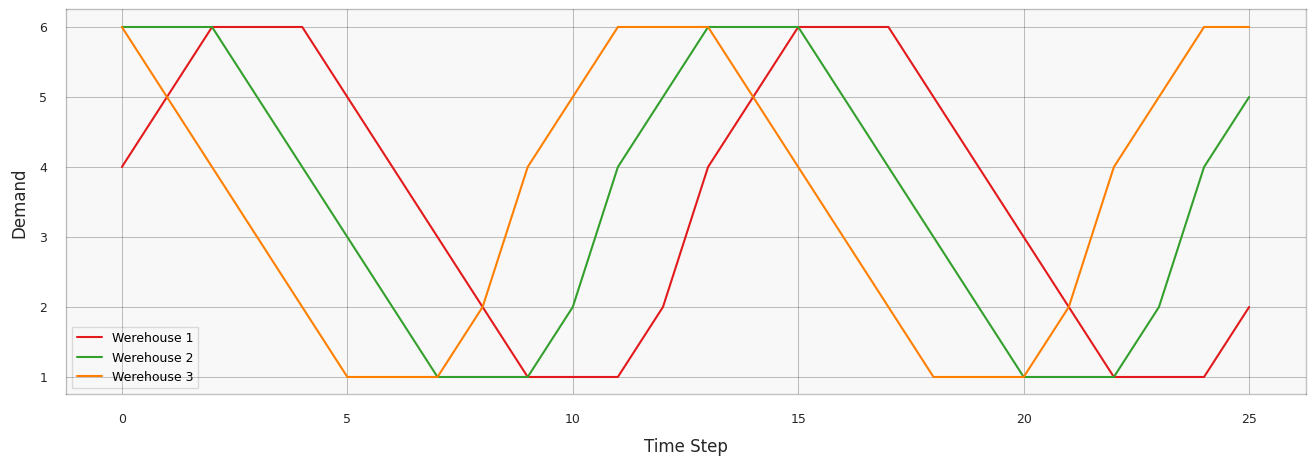

In [ ]:
env = SupplyChainEnvironment()
demands = np.fromfunction(lambda j, t: env.demand(j,t), (env.warehouse_num, env.T), dtype=int)
plt.figure(figsize = (16, 5))
plt.xlabel("Time Step")
plt.ylabel("Demand")
plt.plot(range(env.T), demands.T)
plt.legend([f'Werehouse {i+1}' for i in range(env.warehouse_num)])

In [ ]:
def prepare_metric_plot(plots_n, n, ylabel):
    plt.subplot(plots_n, 1, n)
    plt.ylabel(ylabel)
    plt.tick_params(axis='x', which='both', bottom=True, top=True, labelbottom=False)

# visualizing one episode - stock levels, production and reorderign actions, and rewards
def visualize_transitions(transitions):
    state_trace, action_trace, reward_trace = (transitions.T[0], transitions.T[1], transitions.T[2])
    plots_n = 10
    mpl.rcParams['lines.linewidth'] = 2
    print(f"Return is {sum(reward_trace)}")

    fig = plt.figure(figsize=(8, 12))
    prepare_metric_plot(plots_n, 1, "Stock,\n Factory")
    plt.plot(range(env.T), list(map(lambda s: s.factory_stock, state_trace)), c='purple', alpha=0.5)

    for w in range(env.warehouse_num):
        prepare_metric_plot(plots_n, 2 + w, f"Stock,\n WH {w+1}")
        plt.plot(range(env.T), list(map(lambda s: s.warehouse_stock[w], state_trace)), c='purple', alpha=0.5)

    prepare_metric_plot(plots_n, 5, "Production")
    plt.plot(range(env.T), list(map(lambda a: a.production_level, action_trace)), c='blue', alpha=0.5)

    for w in range(env.warehouse_num):
        prepare_metric_plot(plots_n, 6 + w, f"Shipment,\n WH {w+1}")
        plt.plot(range(env.T), list(map(lambda a: a.shippings_to_warehouses[w], action_trace)), c='blue', alpha=0.5)

    prepare_metric_plot(plots_n, 9, "Profit")
    plt.plot(range(env.T), reward_trace, c='red', alpha=0.9, linewidth=2)

    plt.subplot(plots_n, 1, 10)
    plt.ylabel("Cumulative\nprofit")
    plt.ylim(0, 10000)
    plt.plot(range(env.T), np.cumsum(reward_trace), c='red', alpha=0.9, linewidth=2)
    plt.xlabel("Time step")

In [ ]:
class SQPloicy(object):
  def __init__(self, factory_safety_stock, factory_reorder_amount, safety_stock, reorder_amount):
    self.factory_safety_stock = factory_safety_stock
    self.factory_reorder_amount = factory_reorder_amount
    self.safety_stock = safety_stock
    self.reorder_amount = reorder_amount

  def select_action(self, state):
        action = Action(state.warehouse_num)
        for w in range(state.warehouse_num):
            if state.warehouse_stock[w] < self.safety_stock[w]:
                action.shippings_to_warehouses[w] = self.reorder_amount[w]

        if state.factory_stock - np.sum(action.shippings_to_warehouses) < self.factory_safety_stock:
            action.production_level = self.factory_reorder_amount
        else:
            action.production_level = 0
        return action
def simulate_episode(env, policy):
    state = env.initial_state()
    transitions = []
    for t in range(env.T):
        action = policy.select_action(state)
        state, reward, _ = env.step(state, action)
        transitions.append([state, action, reward])
    return transitions

# basic policy evaluation process
def simulate(env, policy, num_episodes):
    returns_trace = []
    for episode in range(num_episodes):
        env.reset()
        returns_trace.append( sum(np.array(simulate_episode(env, policy)).T[2]) )
    return returns_trace

In [ ]:
!pip install ax-platform
from ax import optimize

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 53.3 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [ ]:
from ax import optimize
import numpy as np

def func(p):
    # Correct the policy class name from SQPolicy to SQPloicy
    policy = SQPloicy(
        p['factory_s'],
        p['factory_Q'],
        [p['w1_s'], p['w2_s'], p['w3_s']],
        [p['w1_Q'], p['w2_Q'], p['w3_Q']]
    )

    try:
        # Run the simulation and return the mean performance across episodes
        returns = simulate(env, policy, num_episodes=30)
        # Ensure returns is not empty and contains numeric values
        if returns and all(isinstance(x, (int, float)) for x in returns):
            return np.mean(returns)
        else:
            print("Simulation returned invalid results:", returns)
            return -np.inf # Return a low value if results are invalid
    except Exception as e:
        print(f"Error during simulation: {e}")
        # Return a very low value in case of an error to avoid optimization failure
        return -np.inf

# Optimization code
best_parameters, best_values, experiment, model = optimize(
    parameters=[
        {"name": "factory_s", "type": "range", "bounds": [0.0, 30.0]},
        {"name": "factory_Q", "type": "range", "bounds": [0.0, 30.0]},
        {"name": "w1_s", "type": "range", "bounds": [0.0, 20.0]},
        {"name": "w1_Q", "type": "range", "bounds": [0.0, 20.0]},
        {"name": "w2_s", "type": "range", "bounds": [0.0, 20.0]},
        {"name": "w2_Q", "type": "range", "bounds": [0.0, 20.0]},
        {"name": "w3_s", "type": "range", "bounds": [0.0, 20.0]},
        {"name": "w3_Q", "type": "range", "bounds": [0.0, 20.0]}
    ],
    evaluation_function=func,
    minimize=False,
    total_trials=10,
)



[INFO 09-30 07:14:16] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter factory_s. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 09-30 07:14:16] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter factory_Q. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 09-30 07:14:16] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter w1_s. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 09-30 07:14:16] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter w1_Q. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parame

In [ ]:
display(best_parameters)
display(best_values)

{'factory_s': 5.4623994044959545,
 'factory_Q': 28.890893133357167,
 'w1_s': 5.743734668940306,
 'w1_Q': 15.67548755556345,
 'w2_s': 1.2947062402963638,
 'w2_Q': 13.900982271879911,
 'w3_s': 7.388400882482529,
 'w3_Q': 19.89700213074684}

({'objective': -3105.9909948951254}, {'objective': {'objective': nan}})

Reward: mean 7279.05, standard deviation 638.6039050146812


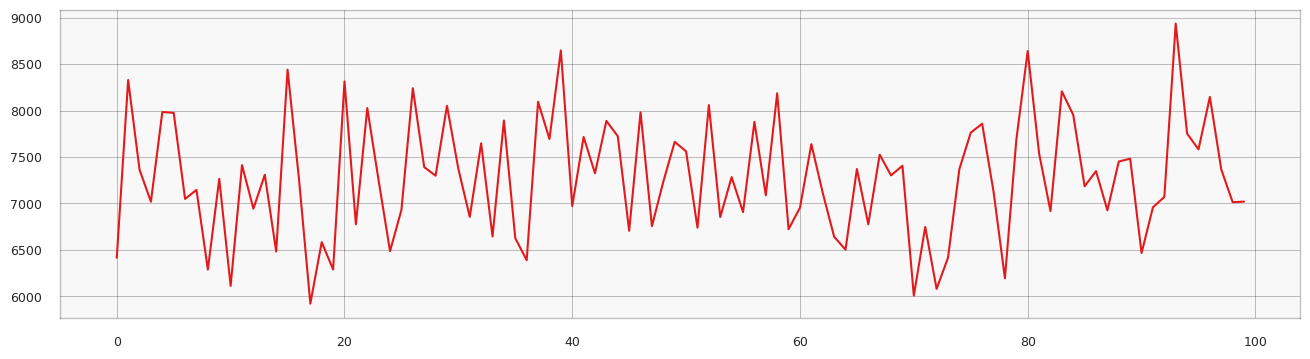

In [ ]:
# ipython-input-15-49d4b60f598b
# evaluating the winning (s,Q) policy more accurately
env = SupplyChainEnvironment()
# Correct the policy class name from SQPolicy to SQPloicy:
policy_sQ = SQPloicy(0.0, 20.0, [5, 5, 5], [5, 5, 10])
return_trace = simulate(env, policy_sQ, num_episodes = 100)
plt.figure(figsize=(16, 4))
plt.plot(range(len(return_trace)), return_trace)
print(f"Reward: mean {np.mean(return_trace)}, standard deviation {np.std(return_trace)}")

Return is 7668.0


<ipython-input-11-98203341795e>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(plots_n, 1, n)


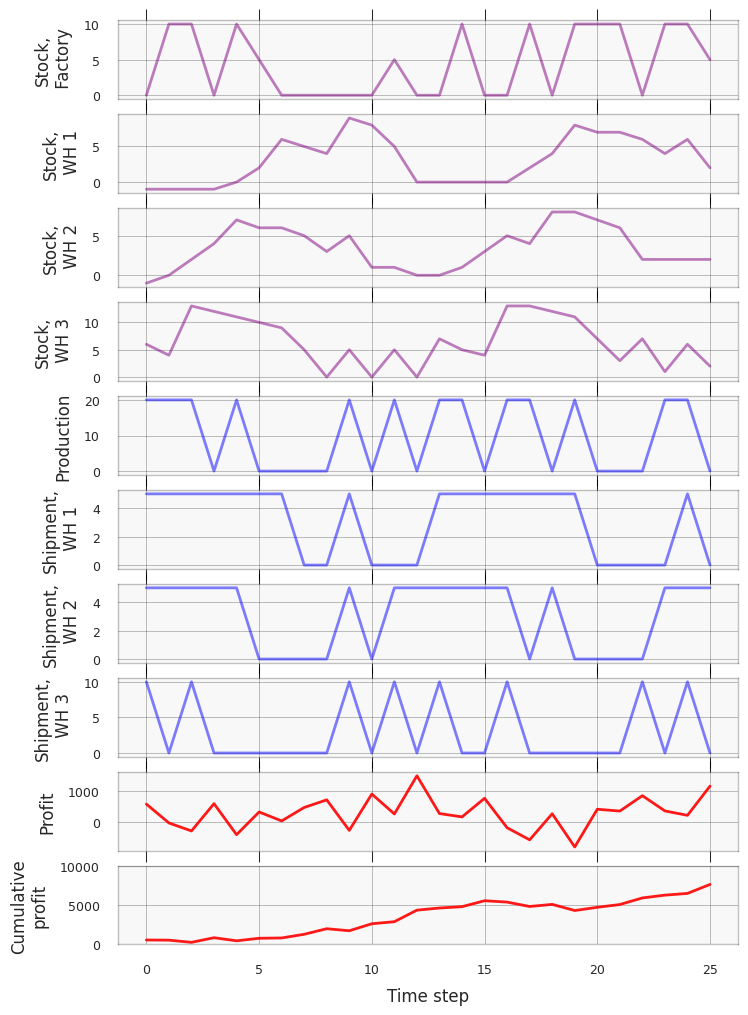

In [ ]:
# tracing the winning (s,Q)  policy
env = SupplyChainEnvironment()
transitions_sQ = simulate_episode(env, policy_sQ)
visualize_transitions(np.array(transitions_sQ))

In [ ]:
from sklearn.model_selection import ParameterGrid

p_grid1 = [5, 10, 20]
p_grid2 = [5, 10, 20]
param_grid = {
    'factory_s': p_grid1,
    'factory_Q': p_grid1,
    'w1_s': p_grid2,
    'w2_s': p_grid2,
    'w3_s': p_grid2,
    'w1_Q': p_grid2,
    'w2_Q': p_grid2,
    'w3_Q': p_grid2,
    }

env = SupplyChainEnvironment()
grid = ParameterGrid(param_grid)
i = 0
best_return = float('-inf')
for p in grid:
    # Change 'SQPolicy' to 'SQPloicy' to match the class name used in other cells:
    policy = SQPloicy( # This line was changed to use SQPloicy
        p['factory_s'], p['factory_Q'],
        [ p['w1_s'], p['w2_s'], p['w3_s'], ],
        [ p['w1_Q'], p['w2_Q'], p['w3_Q'], ]
    )
    m_return = np.mean(simulate(env, policy, num_episodes = 10))
    if m_return > best_return:
        best_return = m_return
        best_params = p

    if i % 100 == 0:
        print(f"Configuration #{i} -- {best_return}")
    i += 1

Configuration #0 -- -141470.7
Configuration #100 -- -141470.7
Configuration #200 -- -141470.7
Configuration #300 -- -141470.7
Configuration #400 -- -141470.7
Configuration #500 -- -141470.7
Configuration #600 -- -141470.7
Configuration #700 -- -141470.7
Configuration #800 -- -141470.7
Configuration #900 -- -141470.7
Configuration #1000 -- -141470.7
Configuration #1100 -- -141470.7
Configuration #1200 -- -141470.7
Configuration #1300 -- -141470.7
Configuration #1400 -- -141470.7
Configuration #1500 -- -141470.7
Configuration #1600 -- -141470.7
Configuration #1700 -- -141470.7
Configuration #1800 -- -141470.7
Configuration #1900 -- -141470.7
Configuration #2000 -- -141470.7
Configuration #2100 -- -141470.7
Configuration #2200 -- -3401.5
Configuration #2300 -- -3279.2
Configuration #2400 -- -3279.2
Configuration #2500 -- -3279.2
Configuration #2600 -- -3279.2
Configuration #2700 -- -3279.2
Configuration #2800 -- -3279.2
Configuration #2900 -- -3279.2
Configuration #3000 -- -3279.2
Configu

In [ ]:
!pip install gym
#!pip install ray[rllib]
!pip install ray[tune]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 MB 9.7 MB/s eta 0:00:00


In [ ]:
!pip install ray[rllib]==2.0.0 pydantic==1.10.9

  Using cached ray-2.0.0-cp310-cp310-manylinux2014_x86_64.whl.metadata (11 kB)
Using cached ray-2.0.0-cp310-cp310-manylinux2014_x86_64.whl (59.1 MB)
  Attempting uninstall: ray
    Found existing installation: ray 2.37.0
    Uninstalling ray-2.37.0:
      Successfully uninstalled ray-2.37.0


In [ ]:
!pip show ray

Name: ray
Version: 2.37.0
Summary: Ray provides a simple, universal API for building distributed applications.
Home-page: https://github.com/ray-project/ray
Author: Ray Team
Author-email: ray-dev@googlegroups.com
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: aiosignal, click, filelock, frozenlist, jsonschema, msgpack, packaging, protobuf, pyyaml, requests
Required-by: 


In [ ]:
!pip install torch

In [ ]:
import numpy as np
import gym
from gym.spaces import Box

import ray
from ray.rllib.utils import try_import_tf

import ray.rllib.agents.ddpg as ddpg
from ray.tune.logger import pretty_print

tf = try_import_tf()

# gym environment adapter
class SimpleSupplyChain(gym.Env):
    def __init__(self, config):
        self.reset()
        self.action_space = Box(low=0.0, high=20.0, shape=(self.supply_chain.warehouse_num + 1, ), dtype=np.int16)
        self.observation_space = Box(-10000, 10000, shape=(len(self.supply_chain.initial_state().to_array()), ), dtype=np.float32)

    def reset(self):
        self.supply_chain = SupplyChainEnvironment()
        self.state = self.supply_chain.initial_state()
        return self.state.to_array()

    def step(self, action):
        action_obj = Action(self.supply_chain.warehouse_num)
        action_obj.production_level = action[0]
        action_obj.shippings_to_warehouses = action[1:]
        self.state, reward, done = self.supply_chain.step(self.state, action_obj)
        return self.state.to_array(), reward, done, {}

ray.shutdown()
ray.init()

def train_ddpg():
    config = ddpg.DEFAULT_CONFIG.copy()
    config["log_level"] = "WARN"
    config["actor_hiddens"] = [512, 512]
    config["critic_hiddens"] = [512, 512]
    config["gamma"] = 0.95

    # Replace timesteps_per_iteration
    config["min_train_timesteps_per_iteration"] = 1000

    # Update replay buffer capacity
    config["replay_buffer_config"] = {
        "capacity": 10000  # Replaces buffer_size
    }

    config["target_network_update_freq"] = 5

    trainer = ddpg.DDPGTrainer(config=config, env=SimpleSupplyChain)
    for i in range(200):
        result = trainer.train()
        print(pretty_print(result))
        checkpoint = trainer.save()
        print("Checkpoint saved at", checkpoint)

train_ddpg()


2024-09-30 08:45:38,132	INFO worker.py:1518 -- Started a local Ray instance.
2024-09-30 08:45:40,690	INFO algorithm.py:1871 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2024-09-30 08:45:40,693	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!
2024-09-30 08:45:40,698	INFO simple_q.py:293 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting `simple_optimizer=True` if this doesn't work for you.
2024-09-30 08:45:40,704	INFO algorithm.py:351 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/usr/local/lib/python3.10/dist-packag

NameError: name 'SupplyChainEnvironment' is not defined

In [ ]:
import numpy as np
import collections
import ray
from ray import tune
from ray.rllib.agents.ddpg import DDPGTrainer
from ray.tune.registry import register_env
import gym
from gym import spaces

# Define the custom supply chain environment inheriting from gym.Env
class SupplyChainEnvironment(gym.Env):
    def __init__(self, config):
        self.T = 26  # episode duration
        self.warehouse_num = 3
        self.d_max = 5  # maximum demand, units
        self.d_var = 2  # maximum random demand variation, units

        self.unit_price = 100  # unit price in dollars
        self.unit_cost = 40  # unit cost in dollars

        self.storage_capacities = np.fromfunction(lambda j: 10*(j+1), (self.warehouse_num + 1,), dtype=int)
        self.storage_costs = np.fromfunction(lambda j: 2*(j+1), (self.warehouse_num + 1,), dtype=int)
        self.transportation_costs = np.fromfunction(lambda j: 5*(j+1), (self.warehouse_num,), dtype=int)
        self.penalty_unit_cost = self.unit_price

        # Gym spaces (Updated to match the actual observation size, i.e., 17 elements)
        self.action_space = spaces.Box(low=0, high=1, shape=(self.warehouse_num + 1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(17,), dtype=np.float32)  # Update to (17,)

        self.reset()  # Initialize the environment state

    def reset(self):
        # Initialize the random generator with a seed to ensure determinism and avoid serialization issues
        seed = np.random.randint(0, 10000)  # Generate a seed for each episode
        np.random.seed(seed)  # Set the seed for the global generator
        #self.rng = np.random.default_rng(seed)  # Use the seed to create a new generator

        self.demand_history = collections.deque(maxlen=4)

        # Initialize the demand history with zeros to avoid empty concatenation
        for _ in range(4):
            self.demand_history.append(np.zeros(self.warehouse_num))

        self.t = 0
        # Initialize factory and warehouse stock variables
        self.factory_stock = 0
        self.warehouse_stock = np.zeros(self.warehouse_num)
        return self._get_obs()

    def step(self, action):
        # Use the seeded random generator created in reset()
        demands = np.random.randint(0, self.d_max, size=self.warehouse_num)

        # Update state variables based on the action taken
        self.factory_stock += action[0]  # assuming first element in action is production level
        self.warehouse_stock += action[1:]  # assuming rest are shippings to warehouses

        # Example demand and reward calculation (adjust based on your business logic)
        total_revenue = np.sum(demands * self.unit_price)
        total_cost = np.sum(self.warehouse_stock * self.unit_cost)  # Adjust to fit your model

        # Define reward as profit (revenue - cost) in this example
        reward = total_revenue - total_cost

        # Check if the episode has ended
        done = self.t == self.T - 1
        self.t += 1

        # Get the next observation
        next_state = self._get_obs()

        return next_state, reward, done, {}

    def _get_obs(self):
        # Ensure dtype matches the observation space dtype (float32)
        obs = np.concatenate(([self.factory_stock], self.warehouse_stock, np.hstack(self.demand_history), [self.t]))
        return obs.astype(np.float32)  # Convert to float32 to match observation space

    def demand(self, warehouse, t):
        # Use the same seeded random generator for generating demand
        return np.random.randint(0, self.d_max)

# Register custom environment
register_env("supply_chain", lambda config: SupplyChainEnvironment(config))

# Configure and train DDPG agent
config = {
    "env": "supply_chain",
    "framework": "torch",
    "num_gpus": 0,
    "num_workers": 1,
    "exploration_config": {
        "type": "OrnsteinUhlenbeckNoise",  # Removed sigma and theta
    },
}

ray.init(ignore_reinit_error=True)
trainer = DDPGTrainer(config=config)
for i in range(100):
    result = trainer.train()
    print(f"Iteration {i}: reward = {result['episode_reward_mean']}")


2024-09-30 10:35:33,525	INFO worker.py:1351 -- Calling ray.init() again after it has already been called.
2024-09-30 10:35:33,533	WARNING deprecation.py:47 -- DeprecationWarning: `config['multiagent']['replay_mode']` has been deprecated. config['replay_buffer_config']['replay_mode'] This will raise an error in the future!
/usr/local/lib/python3.10/dist-packages/ray/_private/ray_option_utils.py:266: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  warnings.warn(


(scheduler +3h16m45s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(pid=98044) /usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
(pid=98044)   from jax import xla_computation as _xla_computation
(pid=98044) /usr/local/lib/python3.10/dist-packages/ray/tune/logger/tensorboardx.py:35: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
(pid=98044)   VALID_NP_HPARAMS = (np.bool8, np.float32, np.float64, np.int32, np.int64)
(pid=98044) /usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(pid=98044)   if (distutils.version.LooseVersion(tf.__version__) <
(RolloutWorker pid=98044) /usr/local/lib/python3.10/d

RaySystemError: System error: RandomNumberGenerator._generator_ctor() takes from 0 to 1 positional arguments but 2 were given
traceback: Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 352, in deserialize_objects
    obj = self._deserialize_object(data, metadata, object_ref)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 241, in _deserialize_object
    return self._deserialize_msgpack_data(data, metadata_fields)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 196, in _deserialize_msgpack_data
    python_objects = self._deserialize_pickle5_data(pickle5_data)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/serialization.py", line 184, in _deserialize_pickle5_data
    obj = pickle.loads(in_band, buffers=buffers)
TypeError: RandomNumberGenerator._generator_ctor() takes from 0 to 1 positional arguments but 2 were given
